In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import sys
import piso                       # Provide methods for intervals

import dmv_test_input as dti      # Local library to read and prep data 

In [2]:
# Intitalize data and parameters

def read_data():
    # Read and cleanse data from akts log and risk database
    df, risk = dti.dmv_risk_input(case=2, save=False)
    
    # Time in minutes. 
    # elapsed time from start to end of test. Sometimes they are out of order.
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
                       
    return df, risk

df, risk = read_data()

changept = 14.5                   # The passing rate changes at the changept
sbin, ebin, inc = (10, 100, 5)



Original length of sample data is 152519
2415 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1056 tests


Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'


In [3]:
# Drop rows in akts where ip has undefined risk<0. They are probably 10. or 192.. nets
df.drop(df[df.score < 0].index, inplace=True)


In [4]:
# Here's what the risk object looks like
for i, k in enumerate(risk.risk):
    if i>0: break
    for j, k1 in enumerate(risk.risk[k]):
        if k1=='risk_comment': continue
        print(f'{k1:<12} {risk.risk[k][k1]}')
    print()


ip           2.57.169.44
score        67
risk         high
address      ['P.O. Box 10096']
postalcode   1001EB
state        nan
country      Netherlands
countrycode  NL
organization RIPE Network Coordination Centre
city         Amsterdam
handle       RIPE
timestamp    01:28:2022 07:40:35



In [5]:
col = ['TestStartDateTime', 'TestEndDateTime', 'TotalScore', 'TotalTimeSpent', 
       'Email', 'ip', 'duration', 'risk', 'score', 'passed']


In [6]:
# A standard form of the Interval object
# dob=lambda s,e,inc:[pd.Interval(i,i+inc,closed='left') if i<e-inc else pd.Interval(i,i+inc,closed='both') for i in range(s,e,inc)]
# bins = dob(0, 100, 10)

In [7]:
# Generate bins from 0 to 100 by 10 for find passing rate vs risk

# For lookup (see below) to work all intervals have be closed='right' (,]. To include 0 in the 1st
# bin, a value <0 has to be used. -np.inf is one choice. It may be difficult to plot. Another
# choice is import sys; epsilon=sys.float_info.epsilon. Rounding should let plots work.

# bins = pd.IntervalIndex.from_breaks([-np.inf] + list(np.arange(sbin, ebin+inc, inc)))

# Alternative:
epsilon = sys.float_info.epsilon
bins = pd.IntervalIndex.from_breaks([-epsilon] + list(np.arange(inc, ebin+inc, inc)))
print(f'The risk score is binned using {sbin, ebin, inc=}\n\n{bins=}')

The risk score is binned using sbin, ebin, inc=(10, 100, 5)

bins=IntervalIndex([(-2.220446049250313e-16, 5.0], (5.0, 10.0], (10.0, 15.0], (15.0, 20.0], (20.0, 25.0] ... (75.0, 80.0], (80.0, 85.0], (85.0, 90.0], (90.0, 95.0], (95.0, 100.0]], dtype='interval[float64, right]')


In [8]:
# Construct dataframe for the risk score rates. It can be used to perform the lookup.
rf = pd.DataFrame({'threshold':bins.left, 'bin': list(range(0,20))}, index=bins)
rf

,threshold,bin
"(-2.220446049250313e-16, 5.0]",-2.220446e-16,0
"(5.0, 10.0]",5.000000e+00,1
"(10.0, 15.0]",1.000000e+01,2
"(15.0, 20.0]",1.500000e+01,3
"(20.0, 25.0]",2.000000e+01,4
"(25.0, 30.0]",2.500000e+01,5
"(30.0, 35.0]",3.000000e+01,6
"(35.0, 40.0]",3.500000e+01,7
"(40.0, 45.0]",4.000000e+01,8
"(45.0, 50.0]",4.500000e+01,9


In [9]:
# Check that the lookup is working
print(f'{piso.lookup(rf, 0).bin!r}')
print(f'{piso.lookup(rf, 70).bin!r}')
print(f'{piso.lookup(rf, 75).bin!r}')
print(f'{piso.lookup(rf, 100).bin!r}')


0    0
Name: bin, dtype: int64
70    13
Name: bin, dtype: int64
75    14
Name: bin, dtype: int64
100    19
Name: bin, dtype: int64


In [10]:
# Identify the bin for each event. bin # is calulated from inc. Lower bound is 0.
# epsilon is used so lower edge is not included in interval.
# Factor 100 used after tests to make sure same results were obtained.
fbin = lambda x: int((x-100*epsilon)/inc)
df['bin'] = df.score.apply(fbin)

# Tried piso intervals. It took too long
# df['bin'] = df.score.apply(lambda x: piso.lookup(rf, x).bin[x])


In [11]:
def find_rate(df):
    # Count # passed and # failed for each (bin, passed.value)
    dr = df.groupby(['bin','passed'])['passed'].count().to_frame(name='count')

    # Reshape the dataframe fromwide to narrow. 
    # The # passed and failed will be in same record so rate can be calculated/
    dr = dr.pivot_table(index=['bin'], columns='passed', values='count')

    # Change the column names. True and False do not work
    dr.columns=['p', 'f']

    # Calculate the passing rate in each bin
    dr['t'] = dr.p + dr.f
    frate = lambda x: x.p/x.t if x.t > 0 else np.nan 
    dr['rate'] = dr.apply(frate, axis=1)

    # Join the bin intervals by bin
    dr = dr.merge(rf, left_on='bin', right_on='bin', how='inner')

    # Cum
    dr['cumpass'] = dr.p.cumsum()
    dr['cumfail'] = dr.f.cumsum()
    dr['cumcount'] = dr.t.cumsum()
    
    return dr

dr = find_rate(df)


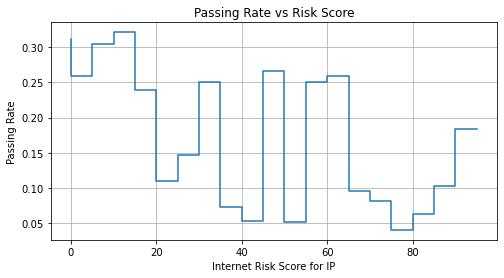

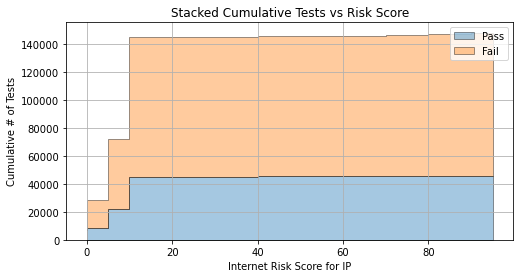

In [12]:
def plot_rate_vs_risk_score(dr):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.plot(dr.threshold, dr.rate, drawstyle='steps')
    
    ax.set_title(f'Passing Rate vs Risk Score')
    ax.set_xlabel(f'Internet Risk Score for IP')
    ax.set_ylabel(f'Passing Rate')
    ax.grid(visible=True)
    plt.show()
    
def plot_cum_vs_risk_score(dr):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.stackplot(dr.threshold, dr.cumpass, dr.cumfail, step='pre', labels=['Pass', 'Fail'], alpha=.4, edgecolor='black')
#     plt.plot(dr.threshold, dr.cumfail, drawstyle='steps', label='Fail')
#     plt.plot(dr.threshold, dr.cumcount, drawstyle='steps', label='Total')
    
    ax.set_title(f'Stacked Cumulative Tests vs Risk Score')
    ax.set_xlabel(f'Internet Risk Score for IP')
    ax.set_ylabel(f'Cumulative # of Tests')
    ax.grid(visible=True)
    plt.legend()
    plt.show()
    
plot_rate_vs_risk_score(dr)
plot_cum_vs_risk_score(dr)


In [13]:
df.shape

(148204, 30)

In [14]:
# Let's see if the effect of risk is different for tests that occur becharge changept
changept = 14.5
# Select data for duration < changept
df1 = df.drop(df[df.duration > changept].index).reset_index()
df1.shape

(30548, 31)

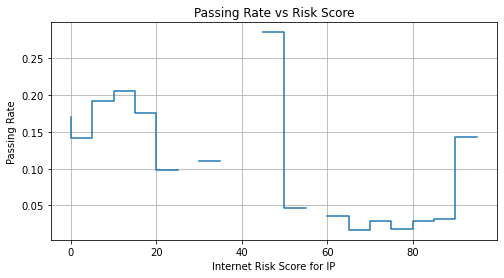

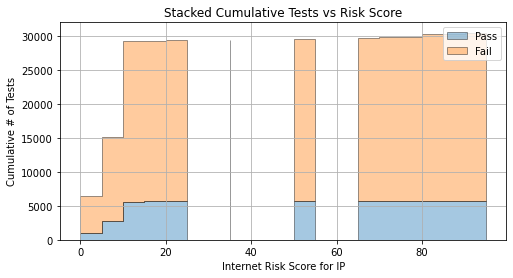

In [15]:
def plot_rates1(df1):
    dr1 = find_rate(df1)
    plot_rate_vs_risk_score(dr1)
    plot_cum_vs_risk_score(dr1)
plot_rates1(df1)

In [16]:
df2 = df.drop(df[df.duration <= changept].index).reset_index()

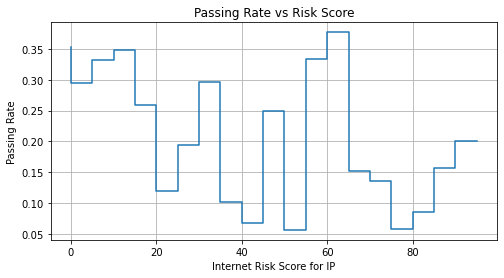

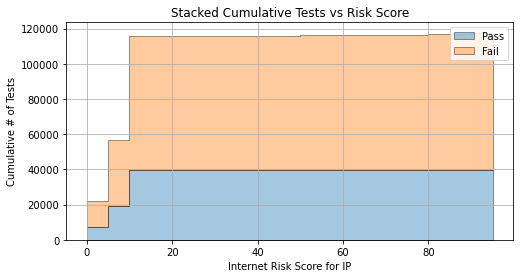

In [17]:
plot_rates1(df2)

In [23]:
np.where(df.IPAddress.str.contains(',') == True)

(array([   790,    843,   1726, ..., 147709, 147864, 148174]),)

In [22]:
df.columns

Index(['index', 'TestAttemptId', 'ExamineeId', 'TestId', 'LocaleId',
       'TestRegistrationDate', 'TestStartDateTime', 'TestEndDateTime',
       'TotalScore', 'Result', 'TotalQuestions', 'TotalQuestionsCorrect',
       'TotalQuestionsIncorrect', 'TotalTimeSpent', 'LastAnswerDate',
       'IPAddress', 'CreateDate', 'UpdateDate', 'LastLoginDate',
       'FailedAttemptCount', 'MailingAddressId', 'Email', 'ip', 'duration',
       'multiple_ip', 'risk', 'score', 'elapsed', 'passed', 'bin'],
      dtype='object')